# **Principal Component Analysis for Outlier Detection**


El análisis de componentes principales, o PCA, reduce el número de dimensiones en grandes conjuntos de datos a componentes principales que conservan la mayor parte de la información original. Para ello, transforma las variables potencialmente correlacionadas en un conjunto más pequeño de variables, denominadas componentes principales.
### **Hiperparametros del modelo**

| Parámetro             | Descripción                                                                 |
|-----------------------|-----------------------------------------------------------------------------|
| `n_components`        | Número de componentes principales a conservar tras aplicar SVD.             |
| `n_selected_components` | Número de componentes a usar para calcular los scores de outlier.         |
| `contamination`       | Proporción esperada de outliers en los datos (valor entre 0 y 0.5).         |
| `copy`                | Si es `True`, se copia los datos antes de transformarlos.                   |
| `whiten`              | Si es `True`, los componentes obtenidos serán escalados a varianza unitaria.|
| `svd_solver`          | Algoritmo usado para la descomposición SVD (`auto`, `full`, `arpack`, `randomized`). |
| `tol`                 | Tolerancia para considerar pequeñas singularidades (solo con `arpack`).     |
| `iterated_power`      | Número de iteraciones de potencia para el método `randomized`.              |
| `random_state`        | Semilla para generar aleatoriedad reproducible (en métodos aleatorios).     |
| `weighted`            | Si es `True`, pondera las distancias por la varianza explicada.             |
| `standardization`     | Si es `True`, estandariza los datos antes de aplicar PCA.                   |


#### **Importacion librerias**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns
import sys, os
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
plt.style.use('ggplot')
sns.set_context('notebook')


proj_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if proj_root not in sys.path:
    sys.path.insert(0, proj_root)

from PyOD_ADGE.models.principal_component_analysis import PCA

## Demo 
Para mostrar el funcionamiento del algoritmo , se usara el dataset [Dataset de Credit Card Fraud de Kaggle](https://www.kaggle.com/datasets/dhanushnarayananr/credit-card-fraud) , que contiene transacciones de tarjetas de crédito, donde la mayoría son transacciones legítimas y una pequeña fracción son fraudulentas. El objetivo es detectar estas transacciones fraudulentas (outliers) en función de las características de las transacciones , esto quiere decir que se pretende de una manera no supervisada obtener ```fraud```.

In [2]:
url_data='https://drive.google.com/uc?export=download&id=1jGJ-Bam7dR9vH4Y6-677LNNpW-PulLfL'
data=pd.read_csv(url_data,header=0)
data.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [3]:
data.shape

(1000000, 8)

El dataset cargado posee 8 columnas y 1 millon de filas para realizar nuestra prediccion de ```fraud``.
Dividiremos los datos en las caracteristicas y la etiqueta que solo revisaremos hasta el final, pero no pasaremos al entrenamiento.

In [4]:
data['fraud']=data['fraud'].astype(np.int8)
data['fraud'].value_counts()


fraud
0    912597
1     87403
Name: count, dtype: int64

Extraemos una muestra estratificada la cual nos asegura que las clases (Normal Vs. Outlier) estén en proporciones similares a las del dataset completo, evitando el sesgo y mejorando la estabilidad de las métricas.

In [5]:
X_f=data.drop(['fraud'],axis=1)
y_f=data['fraud']
X,_,y,_= train_test_split(X_f,y_f,stratify=y_f,train_size=5000,random_state=42)

In [6]:
y.value_counts()

fraud
0    4563
1     437
Name: count, dtype: int64

Hacemos la estandarización de los datos, de igual manera si se le pasa como parametro ``standarization = True``al constructor, si no están estandarizados los datos, la funcion lo hará internamente.

In [7]:
X=StandardScaler().fit_transform(X)

In [8]:
X.mean(axis=0)

array([ 2.27373675e-17, -2.84217094e-17,  7.81597009e-18,  5.68434189e-18,
       -6.67910172e-17, -1.56319402e-17, -5.54223334e-17])

In [9]:
X.shape

(5000, 7)

### Modelo 1: 2 componentes y SVD_solver auto

Inicializamos el modelo con los hiperparámetros deseados y se le ingresan las caracteristicas a evaluar.
El metodo ``fit`` se encarga de ajustar los hiperparámetros y realizar los respectivos cálculos

In [10]:
model = PCA( contamination=0.01, n_components=2, random_state=42)
model.fit(X)

El metodo ``decision_scores`` se encarga de arrojar por punto un score donde, dependiendo de un umbral que se especifica, si esta punctuacion se pasa del umbral significa que es un outlier, por el contrario si se mantiene por debajo de este umbral se considera un inliner.

In [11]:
model.decision_scores_.shape
model.decision_scores_[0:10]

array([44.22489212, 34.51884423, 28.83252561, 17.49333897, 49.86461282,
       19.07853111, 29.33264862, 17.04380987, 27.63148861, 27.7456041 ])

A partir de estas puntuaciones se hace la categorizacion de si es un outlier o no y se crea una matriz de confusión para analizar el rendimiento del modelo respecto a la clasificación

Threshold for 95%:  52.13923003105487


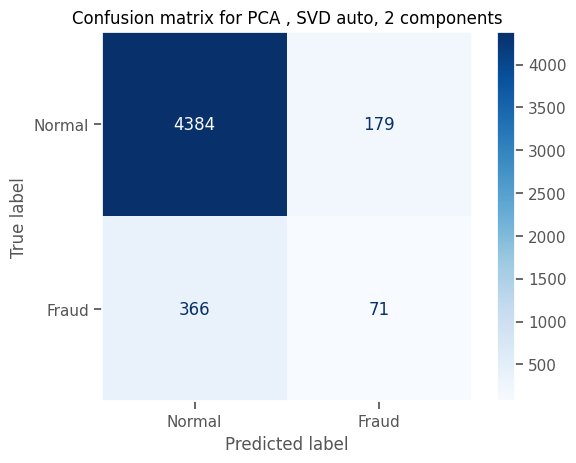

In [12]:
from sklearn.metrics import confusion_matrix

scores = model.decision_function(X)
thresh = np.percentile(model.decision_function(X), 95)
print('Threshold for 95%: ',thresh)
y_predcm = np.where(scores > thresh, 1, 0).astype(int)

cm=confusion_matrix(y,y_predcm)
fig,ax=plt.subplots()
disp=ConfusionMatrixDisplay(cm,display_labels=['Normal','Fraud'])
disp.plot(cmap='Blues',ax=ax,colorbar=True)
ax.set_title('Confusion matrix for PCA , SVD auto, 2 components')
ax.grid(False)
plt.show()

### Modelo 2 : 4 componentes y SVD_solver arckpack
Se realiza el mismo procedimiento con una configuracion de parametros diferente

In [13]:
model2 = PCA( contamination=0.5, svd_solver="arpack", n_components=3, whiten=True , random_state=42)
model2.fit(X)

In [14]:
model2.decision_scores_.shape
model2.decision_scores_[0:10]

array([74.37928698, 55.22778745, 39.98478447, 24.3531277 , 73.44823646,
       25.89991656, 43.62395774, 23.83140532, 39.89752901, 38.70508474])

Threshold for 95%:  80.14844171116694


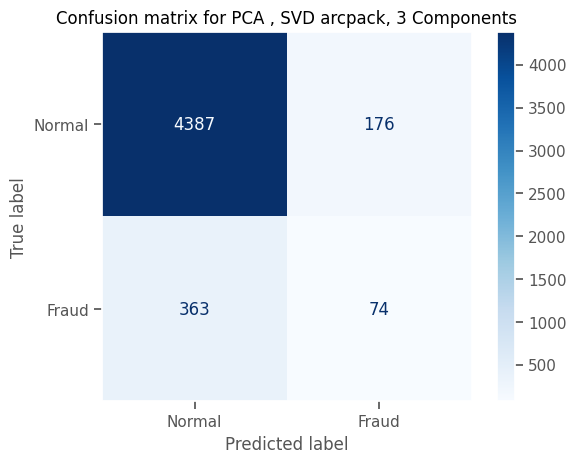

In [15]:
from sklearn.metrics import confusion_matrix

scores = model2.decision_function(X)
thresh = np.percentile(model2.decision_function(X), 95)
print('Threshold for 95%: ',thresh)
y_predcm = np.where(scores > thresh, 1, 0).astype(int)


cm=confusion_matrix(y,y_predcm)
fig,ax=plt.subplots()
disp=ConfusionMatrixDisplay(cm,display_labels=['Normal','Fraud'])
disp.plot(cmap='Blues',ax=ax,colorbar=True)
ax.set_title('Confusion matrix for PCA , SVD arcpack, 3 Components')
ax.grid(False)
plt.show()

# Visualizacion
Usando el metodo ``fit_transform`` realizamos el entrenamiento y hacemos una reduccion de dimensionalidad para asi poder graficar las respectivas salidas.

In [ ]:
print(f'Porcentaje capturado por las componentes: {sum(model.explained_variance_ratio_)}%')
print(model.explained_variance_ratio_)
X_2D= model.fit_transform(X)

[0.16371551 0.14882607]


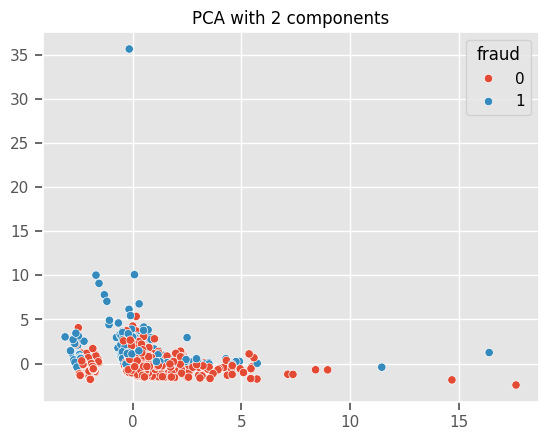

In [17]:
fig,ax=plt.subplots()
sns.scatterplot(x=X_2D[:,0],y=X_2D[:,1],hue=y,ax=ax)
ax.set_title('PCA with 2 components')
plt.show()

In [25]:
print(f'Porcentaje capturado por las componentes:{round(sum(model2.explained_variance_ratio_),3)}%')
print(model2.explained_variance_ratio_)
X_pca= model2.fit_transform(X)

Porcentaje capturado por las componentes:0.457%
[0.16371551 0.14882607 0.14427251]


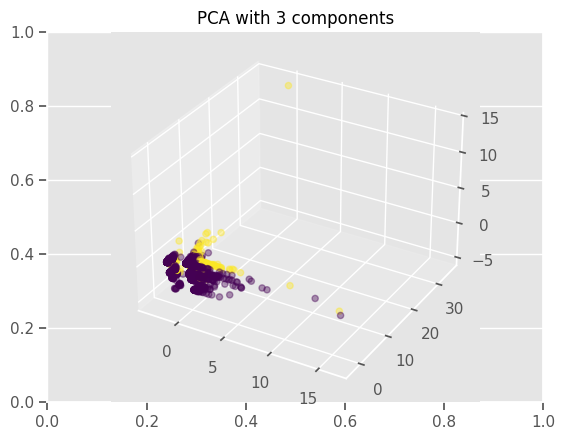

In [19]:
fig,ax=plt.subplots()
ax = plt.axes(projection="3d")
ax.scatter3D(X_pca[:,0],X_pca[:,1],X_pca[:,2],c=y, alpha=0.4)
ax.set_title('PCA with 3 components')
plt.show()

### Modelo 3 : 6 componentes y svd Full
Usando mas componentes podemos capturar mas informacion pero no podemos graficarla correctamente, usaremos un modelo con mas componentes que capte mas varianza para hacer la deteccion de outliers

In [27]:
model3 = PCA( contamination=0.2, svd_solver="full", n_components=6, whiten=True , random_state=42)
model3.fit(X)
print(f'Porcentaje capturado por las componentes: {sum(model3.explained_variance_ratio_)}%')
print(model3.explained_variance_ratio_)

Porcentaje capturado por las componentes: 0.8776435037779525%
[0.16371551 0.14882607 0.14427251 0.14125217 0.14022239 0.13935485]


Threshold for 95%:  161.7484527850938


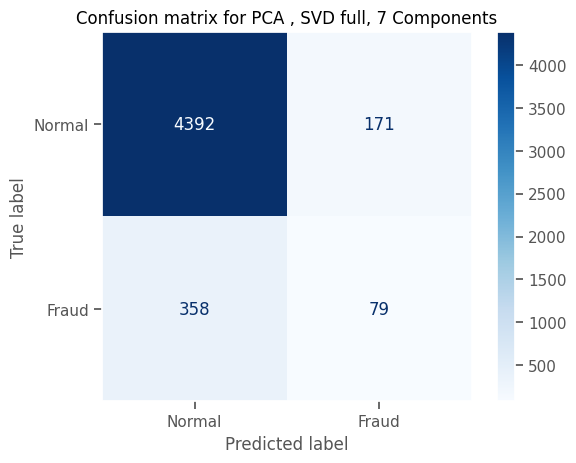

In [28]:
from sklearn.metrics import confusion_matrix

scores = model3.decision_function(X)
thresh = np.percentile(model3.decision_function(X), 95)
print('Threshold for 95%: ',thresh)
y_predcm = np.where(scores > thresh, 1, 0).astype(int)


cm=confusion_matrix(y,y_predcm)
fig,ax=plt.subplots()
disp=ConfusionMatrixDisplay(cm,display_labels=['Normal','Fraud'])
disp.plot(cmap='Blues',ax=ax,colorbar=True)
ax.set_title('Confusion matrix for PCA , SVD full, 7 Components')
ax.grid(False)
plt.show()